# Create Search Engine for MineDojo Youtube Dataset

## Background
I am working on potential solutions for https://www.aicrowd.com/challenges/neurips-2022-minerl-basalt-competition. The goal of this search engine is to quickly find relevant youtube videos when searching for examples of tasks. I am going to explore different options to get the best results.


## Explore Dataset

### Imports

In [1]:
from minedojo.data import YouTubeDataset
from IPython.display import YouTubeVideo
from random import randint
from youtube_transcript_api import YouTubeTranscriptApi
from tqdm.notebook import tqdm
import pandas as pd
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
import re

[INFO:minedojo.tasks] Loaded 1572 Programmatic tasks, 1558 Creative tasks, and 1 special task: "Playthrough". Totally 3131 tasks loaded.


### Collect MineDojo Dataset

In [2]:
youtube_dataset = YouTubeDataset(
        full=False,     # full=False for tutorial videos or 
                       # full=True for general gameplay videos
        download=False, # download=True to automatically download data or 
                       # download=False to load data from download_dir
        download_dir="../assets/MineDojo Youtube/" 
                       # default: "~/.minedojo". You can also manually download data from
                       # https://doi.org/10.5281/zenodo.6641142 and put it in download_dir.           
    )

In [3]:
print(len(youtube_dataset))

34472


In [4]:
print(youtube_dataset[0].keys())

dict_keys(['id', 'title', 'link', 'view_count', 'like_count', 'duration', 'fps'])


34196


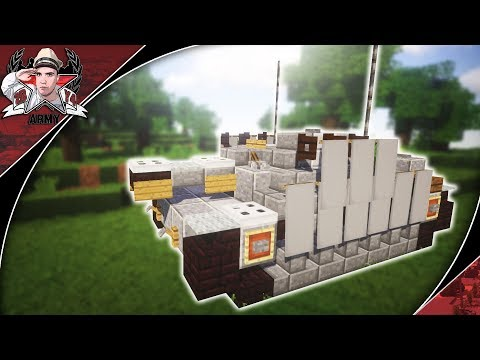

In [5]:
index = randint(0, len(youtube_dataset))
print(index)

YouTubeVideo(youtube_dataset[index]["id"])

In [6]:
srt = YouTubeTranscriptApi.get_transcript(youtube_dataset[index]["id"])
df = pd.DataFrame.from_dict(srt)
df.head()

,text,start,duration
0,hello ladies and gents care to offer,6.379,3.641
1,here bringing you another minecraft over,8.460,3.270
2,to vehicle tutorial and this tour we've,10.020,4.580
3,been going ahead and doing the stuff 42,11.730,7.230
4,offs G this vehicle here was a variant,14.600,7.239


### Load all Transcripts
**Off Notebook - I downloaded all of the tutorial transcripts and saved them as {id}.csv**

In [7]:
textPath = "/Volumes/Extreme SSD/Extra Datasets/MineDojo Youtube/" + "transcript_text.csv"
if os.path.exists(textPath):
    df = pd.read_csv(textPath)
else:
    dataDict = []
    for video in tqdm(youtube_dataset):
        try:
            text = ""
            df = pd.read_csv("/Volumes/Extreme SSD/Extra Datasets/MineDojo Youtube/transcripts/" + video['id'] + ".csv")
            for index, row in df.iterrows():
                text += row['text']
            dataDict.append({"Title": video["title"], "ID": video['id'], "Text": text})
        except:
            pass
    df = pd.DataFrame.from_dict(dataDict)
    df['Text'] = df['Text'].str.replace(r'[^\w\s]+', ' ')
    df['Text'] = df['Text'].str.replace("\n", "")
    df['Title'] = df['Title'].str.replace(r'[^\w\s]+', ' ')
    df['Title'] = df['Title'].str.replace("\n", "")
    df.to_csv(textPath, index=False)

In [8]:
df.head(20)

,Title,ID,Text
0,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,Oh Noget away from me you jogger Oh Jen dontse...
1,Minecraft 110 Structure Block Tutorial Guide ...,Rlnx4cTc0yo,hey whats going on guys logzip herecheck out w...
2,Hermitcraft 6 Episode 141 Auto Mining Machine,TBM_TeJyV5Y,in the previous episode of hermitcraftwe spent...
3,Minecraft Prank Portal Tutorial,dZUMdNlFUvw,hello everybody and welcome back toanother min...
4,Minecraft AFK Fishing Farm Tutorial,345QleodDTM,today today Im gonna be showing you howto buil...
5,Police Station Tutorial Minecraft XboxPlaystat...,GUHnOMHbru0,and were back with the new tutorialswing this ...
6,MinecraftGETTING LITTLE KELLY TO THE HOSPITAL,LOTVbOHhQV0,little k and all us yours come on overto see y...
7,Minecraft Tutorial Crying Child Plush Five Nig...,sY_vTKRK4HM,hey guys whats going on my name is tomorgany a...
8,MINECRAFT HOW TO MAKE THE SMALLEST HOUSE YOU C...,itPhPxC7Tjg,low guys almost addicted here and todaywe are ...
9,DIAMONDS Are Officially Being FIXED When Is 11...,FH5z1TrRIjc,hello im fbx toy cat and they didntintend to c...


## Attempt 1: TF-IDF to Pick the Best Video by Search Term (Unigrams)
### Open Data with PySpark

In [9]:
spark = SparkSession \
    .builder \
    .appName("MineDojo Youtube TF-IDF") \
    .getOrCreate()

22/07/30 18:00:01 WARN Utils: Your hostname, Chases-Mac-mini.local resolves to a loopback address: 127.0.0.1; using 192.168.1.2 instead (on interface en0)
22/07/30 18:00:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/07/30 18:00:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
rawData = spark.read.csv(textPath)
transcriptDF = rawData.toDF("Title", "ID", "Text")

In [11]:
transcriptDF.printSchema()

root
 |-- Title: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Text: string (nullable = true)



In [12]:
transcriptDF.show()

+--------------------+-----------+--------------------+
|               Title|         ID|                Text|
+--------------------+-----------+--------------------+
|               Title|         ID|                Text|
|All The Mods Remi...|yxMB0gbW-ak|Oh Noget away fro...|
|Minecraft 110 Str...|Rlnx4cTc0yo|hey whats going o...|
|Hermitcraft 6 Epi...|TBM_TeJyV5Y|in the previous e...|
|Minecraft Prank P...|dZUMdNlFUvw|hello everybody a...|
|Minecraft AFK Fis...|345QleodDTM|today today Im go...|
|Police Station Tu...|GUHnOMHbru0|and were back wit...|
|MinecraftGETTING ...|LOTVbOHhQV0|little k and all ...|
|Minecraft Tutoria...|sY_vTKRK4HM|hey guys whats go...|
|MINECRAFT HOW TO ...|itPhPxC7Tjg|low guys almost a...|
|DIAMONDS Are Offi...|FH5z1TrRIjc|hello im fbx toy ...|
|Minecraft SECOND ...|bU--yjWCrVo|hey guys what is ...|
|Minecraft SAND Ca...|nrT8igWthBo|hey what is up gu...|
|Meet My NEW Mini ...|fF3lkJZOHpo|Right So If I Fig...|
|Minecraft  How to...|MRBuCBwW724|MusicMusicMusi

In [13]:
transcriptDF.filter(transcriptDF.ID.isNull()).count()

0

In [14]:
transcriptDF.filter(transcriptDF.Title.isNull()).count()

0

In [15]:
transcriptDF.filter(transcriptDF.Text.isNull()).count()

0

### Clean Dataset

In [16]:
with open("../assets/stopwords.txt", 'r') as file:
    stopwords = [f.strip() for f in file]
for stopword in stopwords:
    print("'" + stopword + "'")

''ll'
''tis'
''twas'
''ve'
'10'
'39'
'a'
'a's'
'able'
'ableabout'
'about'
'above'
'abroad'
'abst'
'accordance'
'according'
'accordingly'
'across'
'act'
'actually'
'ad'
'added'
'adj'
'adopted'
'ae'
'af'
'affected'
'affecting'
'affects'
'after'
'afterwards'
'ag'
'again'
'against'
'ago'
'ah'
'ahead'
'ai'
'ain't'
'aint'
'al'
'all'
'allow'
'allows'
'almost'
'alone'
'along'
'alongside'
'already'
'also'
'although'
'always'
'am'
'amid'
'amidst'
'among'
'amongst'
'amoungst'
'amount'
'an'
'and'
'announce'
'another'
'any'
'anybody'
'anyhow'
'anymore'
'anyone'
'anything'
'anyway'
'anyways'
'anywhere'
'ao'
'apart'
'apparently'
'appear'
'appreciate'
'appropriate'
'approximately'
'aq'
'ar'
'are'
'area'
'areas'
'aren'
'aren't'
'arent'
'arise'
'around'
'arpa'
'as'
'aside'
'ask'
'asked'
'asking'
'asks'
'associated'
'at'
'au'
'auth'
'available'
'aw'
'away'
'awfully'
'az'
'b'
'ba'
'back'
'backed'
'backing'
'backs'
'backward'
'backwards'
'bb'
'bd'
'be'
'became'
'because'
'become'
'becomes'
'becoming'
'been

In [17]:
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
wordsData = tokenizer.transform(transcriptDF)

remover = StopWordsRemover(stopWords=stopwords, inputCol="words", outputCol="cleanWords")
stopRemoved = remover.transform(wordsData)

hashingTF = HashingTF(inputCol="cleanWords", outputCol = "rawFeatures")
featurizedData = hashingTF.transform(stopRemoved)
featurizedData.show()

+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text|               words|          cleanWords|         rawFeatures|
+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text|              [text]|                  []|      (262144,[],[])|
|All The Mods Remi...|yxMB0gbW-ak|Oh Noget away fro...|[oh, noget, away,...|[noget, jogger, j...|(262144,[161,531,...|
|Minecraft 110 Str...|Rlnx4cTc0yo|hey whats going o...|[hey, whats, goin...|[guys, logzip, he...|(262144,[619,1164...|
|Hermitcraft 6 Epi...|TBM_TeJyV5Y|in the previous e...|[in, the, previou...|[previous, episod...|(262144,[33,763,8...|
|Minecraft Prank P...|dZUMdNlFUvw|hello everybody a...|[hello, everybody...|[toanother, minec...|(262144,[600,921,...|
|Minecraft AFK Fis...|345QleodDTM|today today Im

### Starting IDF Algorithm

In [18]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [19]:
rescaledData.show()

22/07/30 18:00:21 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text|               words|          cleanWords|         rawFeatures|            features|
+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text|              [text]|                  []|      (262144,[],[])|      (262144,[],[])|
|All The Mods Remi...|yxMB0gbW-ak|Oh Noget away fro...|[oh, noget, away,...|[noget, jogger, j...|(262144,[161,531,...|(262144,[161,531,...|
|Minecraft 110 Str...|Rlnx4cTc0yo|hey whats going o...|[hey, whats, goin...|[guys, logzip, he...|(262144,[619,1164...|(262144,[619,1164...|
|Hermitcraft 6 Epi...|TBM_TeJyV5Y|in the previous e...|[in, the, previou..

### Testing With Search Term

In [20]:
schema = StructType([StructField("Text", StringType())])

df = spark.createDataFrame(([["Hey lets Build a house"]]), schema).toDF("Text")
df.show()

+--------------------+
|                Text|
+--------------------+
|Hey lets Build a ...|
+--------------------+



In [21]:
wordsData = tokenizer.transform(df)
stopRemoved = remover.transform(wordsData)
search = hashingTF.transform(stopRemoved)
search.show()

+--------------------+--------------------+--------------+--------------------+
|                Text|               words|    cleanWords|         rawFeatures|
+--------------------+--------------------+--------------+--------------------+
|Hey lets Build a ...|[hey, lets, build...|[build, house]|(262144,[62070,21...|
+--------------------+--------------------+--------------+--------------------+



In [22]:
featureVec = search.select('rawFeatures').collect()
print(featureVec)

[Row(rawFeatures=SparseVector(262144, {62070: 1.0, 211756: 1.0}))]


In [23]:
searchID = int(featureVec[0].rawFeatures.indices[0])
print(searchID)

62070


In [24]:
termExtractor = udf(lambda x: float(x[searchID]), FloatType())

searchDF = rescaledData.withColumn('score', termExtractor(rescaledData.features))
searchDF.show()

22/07/30 18:00:23 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|               Title|         ID|                Text|               words|          cleanWords|         rawFeatures|            features|     score|
+--------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|               Title|         ID|                Text|              [text]|                  []|      (262144,[],[])|      (262144,[],[])|       0.0|
|All The Mods Remi...|yxMB0gbW-ak|Oh Noget away fro...|[oh, noget, away,...|[noget, jogger, j...|(262144,[161,531,...|(262144,[161,531,...| 0.5309786|
|Minecraft 110 Str...|Rlnx4cTc0yo|hey whats going o...|[hey, whats, goin...|[guys, logzip, he...|(262144,[619,1164...|(262144,[619,1164...|       0.0|
|Hermitcraft 6 Epi...|TBM_TeJyV5Y|in the previous e...|[in, the, previou...|[previous, episod.

In [25]:
sortedResults = searchDF.filter("score > 0").orderBy('score', ascending=False).select("Title", "ID", "score")
sortedResults.show(truncate=100)

22/07/30 18:00:28 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+-----------------------------------------------------------------------------------------+-----------+---------+
|                                                                                    Title|         ID|    score|
+-----------------------------------------------------------------------------------------+-----------+---------+
|                                                               MINECRAFT TITANIC TUTORIAL|bxC-488KNJM|53.097862|
|                               Minecraft Pixel Art Tutorial and Showcase Gyarados Pokemon|RfIHTv24G3M|52.035904|
|                              Minecraft Pixel Art Tutorial and Showcase Charizard Pokemon|-zUF2nEFn3o|50.442966|
|                                             Minecraft Pixel Art Tutorial Sylveon Pokemon|cJBjdNgAu38|47.257095|
|                                Minecraft Pixel Art Tutorial and Showcase Pikachu Pokemon|METra8ztolM|47.257095|
|                                                 Minecraft Pixel Art Tutorial Big Chung

### Remarks
Works ok, Issue at the moment is lack of context between words. It is giving me things that have the highest search for both build and house. It also seems that build is said a lot more in these than house, so that is not great.

### Testing with Sampled MineDojo Task

In [26]:
with open("../assets/MineDojoInstructions.txt", 'r') as file:
    instructions = [re.sub(r'[^\w\s]', '', f).strip()[2:] for f in file]
for instruction in instructions:
    print("'" + instruction + "'")

'Find a shulker They can be found in end cities in the end or in the Nether'
'Attack the shulker with your weapon of choice Swords are a good option as they deal extra damage to ender creatures'
'The shulker will teleport away when attacked Keep attacking and it will eventually die'
'Find a shulker They can be found in end cities in the end or in the Nether'
'Attack the shulker with your weapon of choice Swords are a good option as they deal extra damage to ender creatures'
'The shulker will teleport away when attacked Keep attacking and it will eventually die'
'Find a shulker They can be found in end cities in the end or in the Nether'
'Attack the shulker with your weapon of choice Swords are a good option as they deal extra damage to ender creatures'
'The shulker will teleport away when attacked Keep attacking and it will eventually die'
'Find an endermite They are found in the dark either underground or in The End'
'Attack the endermite with your weapon of choice Swords work well as

'rst you need to find a chorus plant Chorus plants are found in the End and can be rare to find Once you have found a chorus plant you need to mine it with a pickaxe Chorus plants are quite tough so it may take a few tries After you have mined the plant you need to place it in a crafting table This will give you a chorus flower'
'Find a chorus plant Chorus plants are tall thin plants that have purple flowers and bluegreen leaves They can be found in the Nether in the End and in the Overworld in desert biomes'
'Break the chorus plant When you break a chorus plant it will drop 13 chorus fruits'
'Pick up the chorus fruits Chorus fruits can be eaten raw or used to craft potions'
'Find a chorus plant Chorus plants are tall thin plants that have purple flowers and bluegreen leaves They can be found in the Nether in the End and in the Overworld in desert biomes'
'Break the chorus plant When you break a chorus plant it will drop 13 chorus fruits'
'Pick up the chorus fruits Chorus fruits can be

'Cut it down'
'Collect the apples'
'Find a cow'
'Rightclick on the cow with your hand to milk it'
'Collect the milk in a bucket'
'Rightclick on the cow with your sword to kill it'
'Rightclick on the dead cow with your hand to harvest the meat'
'Find a cow'
'Rightclick on the cow with your hand to milk it'
'Collect the milk in a bucket'
'Rightclick on the cow with your sword to kill it'
'Rightclick on the dead cow with your hand to harvest the meat'
'Find a cow'
'Rightclick on the cow with your hand to milk it'
'Collect the milk in a bucket'
'Rightclick on the cow with your sword to kill it'
'Rightclick on the dead cow with your hand to harvest the meat'
'Find a cow'
'Rightclick on the cow with your hand to milk it'
'Collect the milk in a bucket'
'Rightclick on the cow with your sword to kill it'
'Rightclick on the dead cow with your hand to harvest the meat'
'Find a cow'
'Rightclick on the cow with your hand to milk it'
'Collect the milk in a bucket'
'Rightclick on the cow with your sw

'Once you have gathered the necessary materials you will need to use a crafting table to create the clock'
'To use the clock simply place it on a wall and rightclick it This will open a menu that will allow you to set the time'
'The first thing you need to do is find a crafting table You can find these in abandoned mineshafts strongholds or villages If you cant find one of these you can always make your own by placing 4 wooden planks in a square on the crafting grid'
'Once you have a crafting table youll need to find some iron ingots These can be found by mining iron ore which can be found in caves or by killing zombies'
'Next youll need to find a piece of redstone This can be found by mining redstone ore which can be found in caves or by killing creepers'
'Finally youll need to find a compass This can be found in chests in abandoned mineshafts strongholds or villages'
'Once you have all of these items you can craft a compass by placing them in the following pattern on the crafting gri

In [27]:
sampleInstruction = instructions[randint(0, len(instructions))]
print(sampleInstruction)

Search the room for a hidden door or trapdoor


In [28]:
schema = StructType([StructField("Text", StringType())])

df = spark.createDataFrame(([[sampleInstruction]]), schema).toDF("Text")
wordsData = tokenizer.transform(df)
stopRemoved = remover.transform(wordsData)
search = hashingTF.transform(stopRemoved)
featureVec = search.select('rawFeatures').collect()
searchID = int(featureVec[0].rawFeatures.indices[0])
termExtractor = udf(lambda x: float(x[searchID]), FloatType())
searchDF = rescaledData.withColumn('score', termExtractor(rescaledData.features))
sortedResults = searchDF.filter("score > 0").orderBy('score', ascending=False).select("Title", "ID", "score")
sortedResults.show(truncate=100)

22/07/30 18:00:54 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+------------------------------------------------------------------------------------------------+-----------+---------+
|                                                                                           Title|         ID|    score|
+------------------------------------------------------------------------------------------------+-----------+---------+
|                                                          25 Ways to Hide your Base in Minecraft|O6b5GeYEJm4| 80.54498|
|                          10 Ways to Hide Your Minecraft Base with NO REDSTONE ok maybe a little|6CuOjBn6VnM| 70.47686|
|                                                  35 REDSTONE CREATIONS THAT WILL BLOW YOUR MIND|W1pL57WDjMI|52.857643|
|Hidden base in a hidden base in a hidden base in a hidden base in a hidden base in a hidden base|BE7VlVEqz08|50.340614|
|                       Minecraft Tutorial How To Make A Secret Library Base Hidden Base Tutorial|RHm_Gpoc4Z0| 37.75546|
|        Minecraft Bedrock  2x2 

### Remarks
The Search needs to be more specific to the moment in the video as apposed to the video itself. If the tutorial is an hour long and I just need 20 seconds, that video is useless most likely for the rest of it.

## Attempt 2: Search at Timestamp

In [29]:
textPath = "/Volumes/Extreme SSD/Extra Datasets/MineDojo Youtube/" + "transcript_text_time.csv"
if os.path.exists(textPath):
    df = pd.read_csv(textPath)
else:
    dataDict = []
    for video in tqdm(youtube_dataset):
        try:
            text = ""
            df = pd.read_csv("/Volumes/Extreme SSD/Extra Datasets/MineDojo Youtube/transcripts/" + video['id'] + ".csv")
            for index, row in df.iterrows():
                text = row['text'].replace(r'[^\w\s]+', ' ').replace("\n", " ").strip()
                if text != "":
                    dataDict.append({"Title": video["title"], "ID": video['id'], "Text": text, "Start": row['start'], "Duration": row['duration']})
        except:
            pass
    df = pd.DataFrame.from_dict(dataDict)
    df['Text'] = df['Text'].str.replace(r'[^\w\s]+', ' ')
    df['Text'] = df['Text'].str.replace("\n", "")
    df['Title'] = df['Title'].str.replace(r'[^\w\s]+', ' ')
    df['Title'] = df['Title'].str.replace("\n", "")
    df.to_csv(textPath, index=False)

In [30]:
df[df["Text"]!=""].head(20)

,Title,ID,Text,Start,Duration
0,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,Oh No,0.030,11.069
1,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,get away from me you jogger Oh Jen don t,5.520,10.890
2,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,see my friend oh my god dude,11.099,6.901
3,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,what are you two freaking quick he is,16.410,4.860
4,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,okay so here we go I m looking up a,18.000,5.220
5,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,little guide on how to make the best,21.270,3.120
6,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,chickens okay,23.220,3.629
7,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,so man yelling provides the best bass,24.390,5.580
8,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,damage but somebody here prefers to use,26.849,6.811
9,All The Mods Remix Testing Jessica 38,yxMB0gbW-ak,half man Yellin half bowed even once,29.970,5.339


In [31]:
rawData = spark.read.csv(textPath)
transcriptDF = rawData.toDF("Title", "ID", "Text", "Start", "Duration")

In [32]:
transcriptDF.printSchema()

root
 |-- Title: string (nullable = true)
 |-- ID: string (nullable = true)
 |-- Text: string (nullable = true)
 |-- Start: string (nullable = true)
 |-- Duration: string (nullable = true)



In [33]:
transcriptDF.show()

+--------------------+-----------+--------------------+------+--------+
|               Title|         ID|                Text| Start|Duration|
+--------------------+-----------+--------------------+------+--------+
|               Title|         ID|                Text| Start|Duration|
|All The Mods Remi...|yxMB0gbW-ak|               Oh No|  0.03|  11.069|
|All The Mods Remi...|yxMB0gbW-ak|get away from me ...|  5.52|   10.89|
|All The Mods Remi...|yxMB0gbW-ak|see my friend oh ...|11.099|   6.901|
|All The Mods Remi...|yxMB0gbW-ak|what are you two ...| 16.41|    4.86|
|All The Mods Remi...|yxMB0gbW-ak|okay so here we g...|  18.0|    5.22|
|All The Mods Remi...|yxMB0gbW-ak|little guide on h...| 21.27|    3.12|
|All The Mods Remi...|yxMB0gbW-ak|       chickens okay| 23.22|   3.629|
|All The Mods Remi...|yxMB0gbW-ak|so man yelling pr...| 24.39|    5.58|
|All The Mods Remi...|yxMB0gbW-ak|damage but somebo...|26.849|   6.811|
|All The Mods Remi...|yxMB0gbW-ak|half man Yellin h...| 29.97|  

In [34]:
tokenizer = Tokenizer(inputCol="Text", outputCol="words")
wordsData = tokenizer.transform(transcriptDF)

remover = StopWordsRemover(stopWords=stopwords, inputCol="words", outputCol="cleanWords")
stopRemoved = remover.transform(wordsData)

hashingTF = HashingTF(inputCol="cleanWords", outputCol = "rawFeatures")
featurizedData = hashingTF.transform(stopRemoved)
featurizedData.show()

+--------------------+-----------+--------------------+------+--------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text| Start|Duration|               words|          cleanWords|         rawFeatures|
+--------------------+-----------+--------------------+------+--------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text| Start|Duration|              [text]|                  []|      (262144,[],[])|
|All The Mods Remi...|yxMB0gbW-ak|               Oh No|  0.03|  11.069|            [oh, no]|                  []|      (262144,[],[])|
|All The Mods Remi...|yxMB0gbW-ak|get away from me ...|  5.52|   10.89|[get, away, from,...|       [jogger, jen]|(262144,[19192,52...|
|All The Mods Remi...|yxMB0gbW-ak|see my friend oh ...|11.099|   6.901|[see, my, friend,...| [friend, god, dude]|(262144,[74520,16...|
|All The Mods Remi...|yxMB0gbW-ak|what are you two ...|

In [35]:
idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
rescaledData = idfModel.transform(featurizedData)

In [36]:
rescaledData.show()

22/07/30 18:01:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
+--------------------+-----------+--------------------+------+--------+--------------------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text| Start|Duration|               words|          cleanWords|         rawFeatures|            features|
+--------------------+-----------+--------------------+------+--------+--------------------+--------------------+--------------------+--------------------+
|               Title|         ID|                Text| Start|Duration|              [text]|                  []|      (262144,[],[])|      (262144,[],[])|
|All The Mods Remi...|yxMB0gbW-ak|               Oh No|  0.03|  11.069|            [oh, no]|                  []|      (262144,[],[])|      (262144,[],[])|
|All The Mods Remi...|yxMB0gbW-ak|get away from me ...|  5.52|   10.89|[get, away, from,...|       [jogger, jen]|(262144,[19192,52...|

In [37]:
sampleInstruction = instructions[randint(0, len(instructions))]
print(sampleInstruction)

Craft a crafting table To do this you will need four blocks of wood Place the blocks of wood in your crafting grid so that they are arranged in a square This will give you a crafting table


In [38]:
schema = StructType([StructField("Text", StringType())])

df = spark.createDataFrame(([[sampleInstruction]]), schema).toDF("Text")
wordsData = tokenizer.transform(df)
stopRemoved = remover.transform(wordsData)
search = hashingTF.transform(stopRemoved)
search.select("Text", "cleanWords").show()

+--------------------+--------------------+
|                Text|          cleanWords|
+--------------------+--------------------+
|Craft a crafting ...|[craft, crafting,...|
+--------------------+--------------------+



In [39]:
featureVec = search.select('rawFeatures').collect()
searchID = int(featureVec[0].rawFeatures.indices[0])
termExtractor = udf(lambda x: float(x[searchID]), FloatType())
searchDF = rescaledData.withColumn('score', termExtractor(rescaledData.features))
sortedResults = searchDF.filter("score > 0").orderBy('score', ascending=False).select("Text", "ID", "score")
sortedResults.show(truncate=100)

22/07/30 18:01:41 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB


+----------------------------------------------------------------------------------------------------+-----------+---------+
|                                                                                                Text|         ID|    score|
+----------------------------------------------------------------------------------------------------+-----------+---------+
|                                                                 you ll just craft craft craft craft|AtY59aM19Uc|26.507183|
|                                                                ready just craft craft craft boots i|2Uexpu8O1xY|19.880388|
|I need oh yeah I need to craft need to craft something I need to craft something with all this st...|O6DcHZAQaBA|19.880388|
|                                                             let s check the craft in terminal craft|AeXveZDPmq8|13.253592|
|                                                             craft a bucket we re not going to craft|Egx0VeAGQLA|13.253592|


### Remarks
I need to adjust the score to ensure a really high score from 1 doesn't over shadow the others.